# Quantum Error Mitigation with Qiskit Runtime

Here we explore the following error mitigation options:

- Dynamical decoupling
- Measurement error mitigation
- Gate twirling
- Zero noise extrapolation (ZNE)

In [ ]:
!pip install qiskit
!pip install qiskit[visualization]==1.1.0
# Use the following if you are on MacOS/zsh
#!pip install 'qiskit[visualization]'==1.1.0
!pip install qiskit_aer
!pip install qiskit_ibm_runtime
!pip install matplotlib
!pip install pylatexenc
!pip install prototype-zne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 16.2 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=6f825d9d33e49f28046657633ab642e8a4b2ebc2feb692b4efa5774f54922b3d
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
  Attempting uninstall: qiskit
    F

In [ ]:
# import of required libraries and modules
import os
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from qiskit.circuit.library import QFT
from qiskit.providers.fake_provider import GenericBackendV2, generic_backend_v2
generic_backend_v2._NOISE_DEFAULTS["cx"] = (5.99988e-06, 6.99988e-06, 1e-5, 5e-3)
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import transpile, QuantumCircuit
from qiskit.circuit import Gate
from qiskit.converters import circuit_to_dag
from qiskit.transpiler import CouplingMap, StagedPassManager, PassManager, AnalysisPass, TransformationPass
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.preset_passmanagers.common import generate_unroll_3q, generate_embed_passmanager
from qiskit.quantum_info import hellinger_fidelity
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.dagcircuit import DAGCircuit
from qiskit_ibm_runtime.fake_provider import FakeTorino
from qiskit.circuit.library import EfficientSU2
from qiskit.circuit.library import UnitaryOverlap
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator, EstimatorOptions, Batch

In [ ]:
os.environ['QXToken'] = 'PASTE YOUR TOKEN FROM IBM QUANTUM ACCOUNT'

In [ ]:
QiskitRuntimeService.save_account(channel='ibm_quantum', token=os.environ['QXToken'])
service = QiskitRuntimeService()

### Quantum problem (circuit and observables)

#### Circuit

Here we use the [`EfficientSU2`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.EfficientSU2) circuit included in Qiskit's circuit library.

EfficientSU2 is a parameterized quantum circuit designed to be efficiently executable on quantum hardware with limited qubit connectivity, while still being expressive enough to solve problems in application domains like optimization and chemistry. It is built by alternating layers of parameterized single-qubit gates with a layer containing a fixed pattern of two-qubit gates, for a chosen number of repetitions. The pattern of two-qubit gates can be specified by the user. Here we can use the built-in pairwise pattern because it minimizes the circuit depth by packing the two-qubit gates as densely as possible.

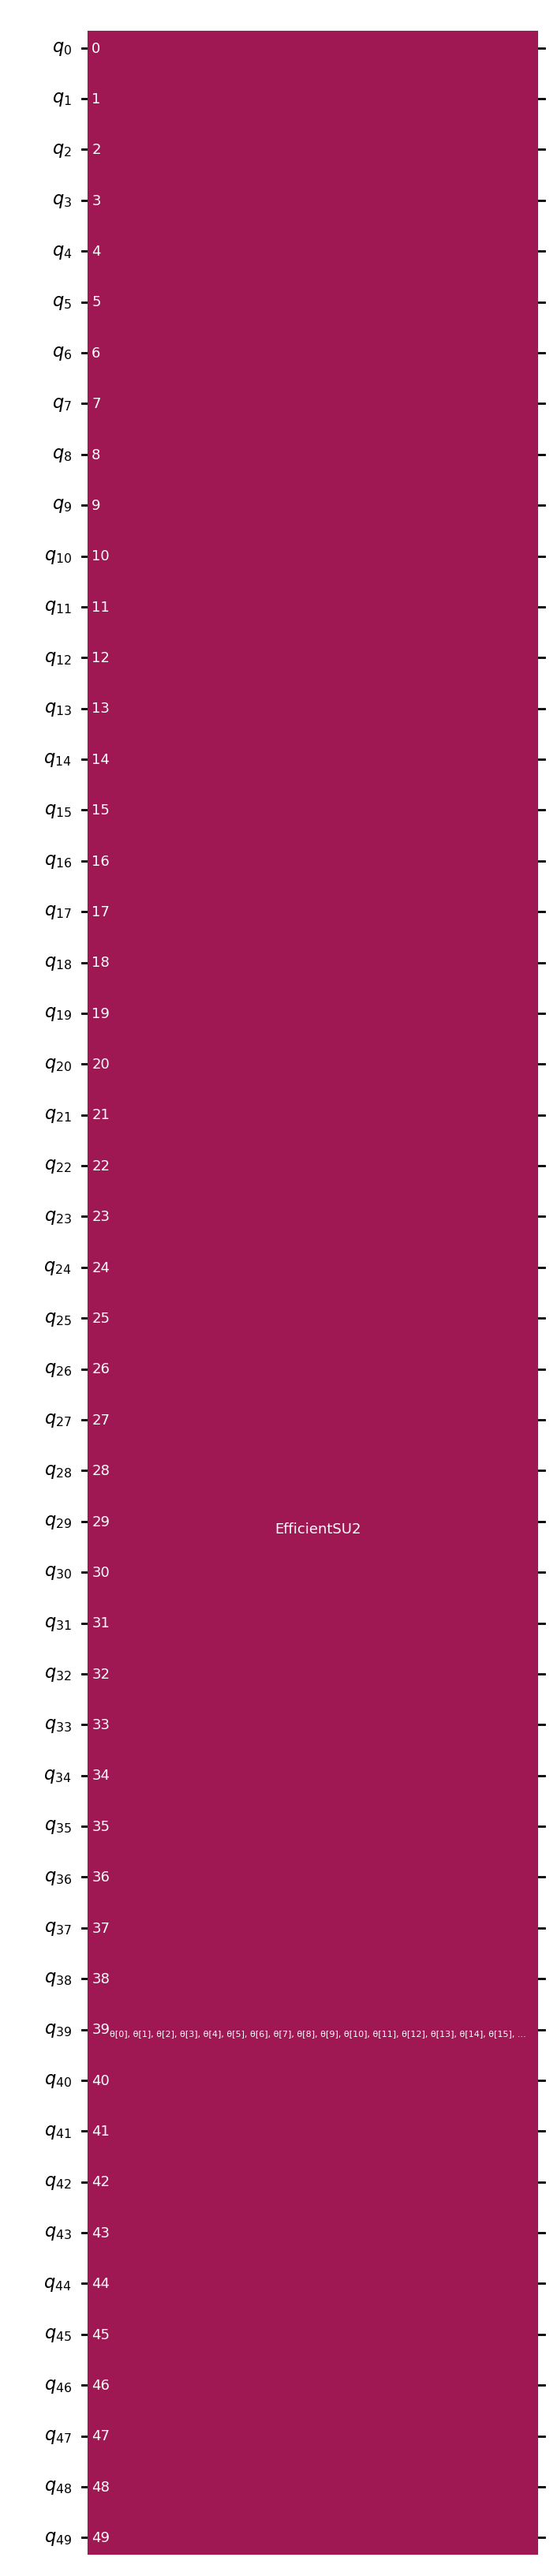

In [ ]:
num_qubits = 50
reps = 2
abstract_circuit = EfficientSU2(num_qubits, reps=reps, entanglement="pairwise")
abstract_circuit.draw('mpl')

##### Assign parameters

Next, create some random parameters and assign them to the circuit.

In [ ]:
num_parameters = abstract_circuit.num_parameters
param_values = np.random.uniform(-np.pi, np.pi, size=num_parameters)

abstract_circuit.assign_parameters(param_values, inplace=True)

##### Append uncompute block

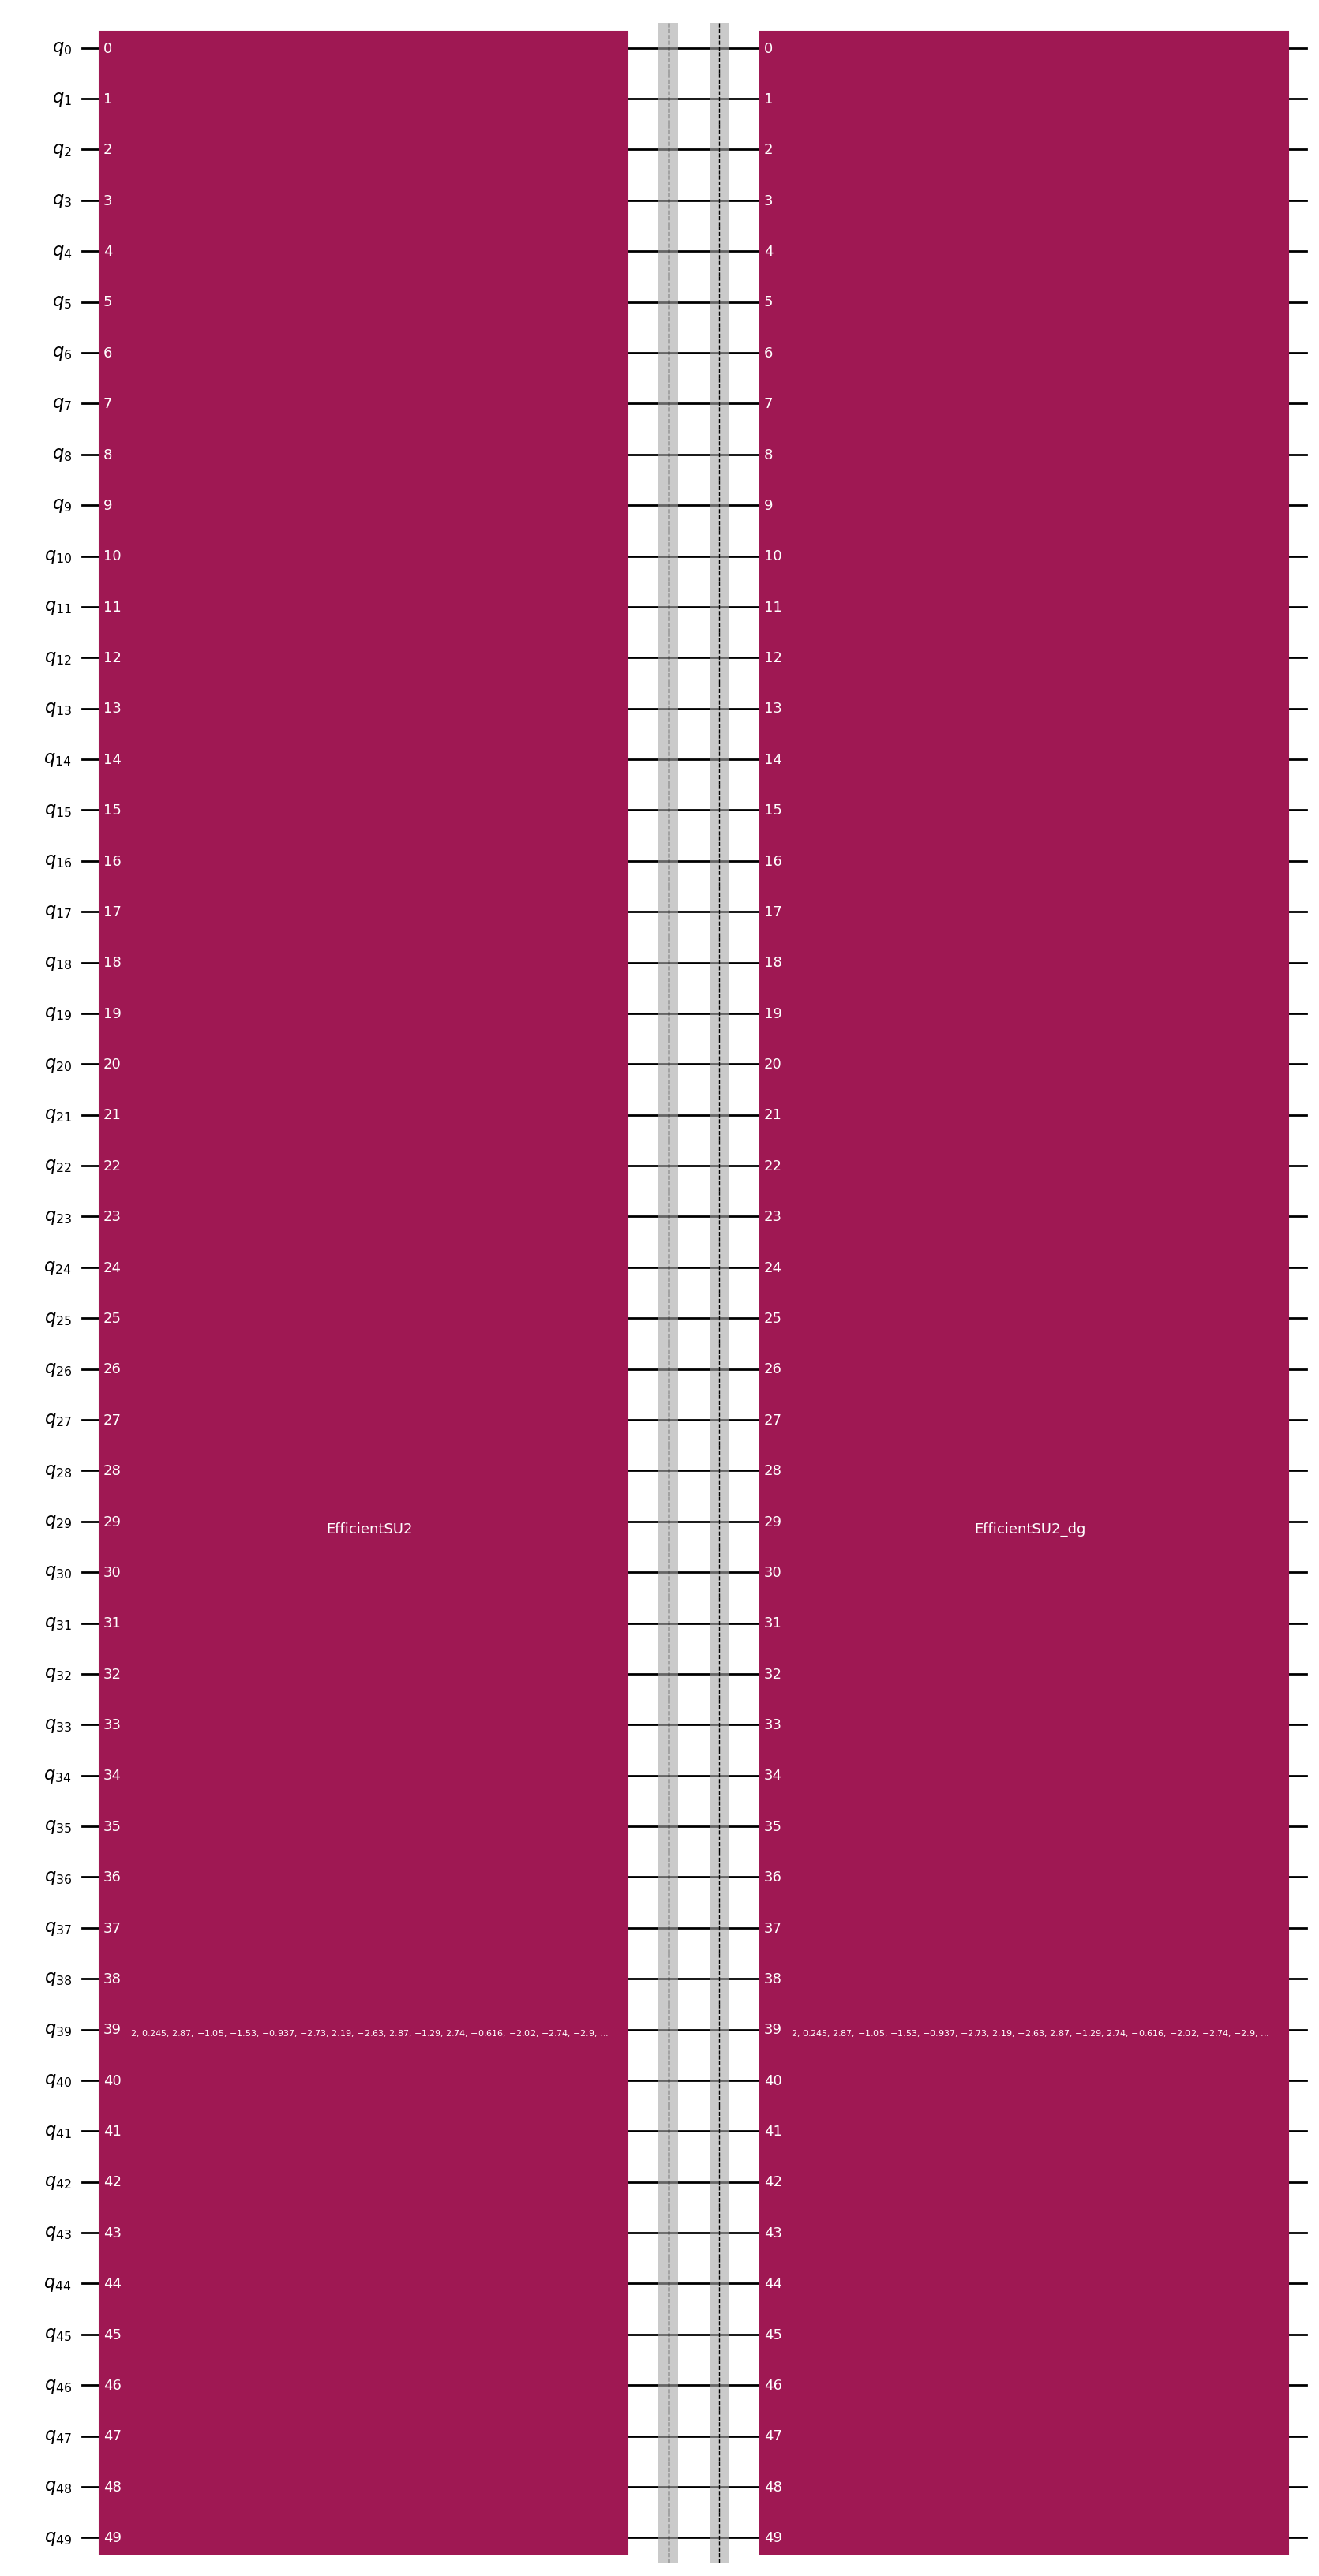

In [ ]:
abstract_circuit.barrier()
abstract_circuit = UnitaryOverlap(abstract_circuit, abstract_circuit)
abstract_circuit.draw('mpl')

#### Observables

Next, define the observables. We create weight-1 $\langle Z_i \rangle$ observables for each qubit in the circuit. Example: For a $4$-qubit abstract circuit, we create $4$ observables each with a single $\langle Z \rangle$ acting on a different qubit, i.e., $IIIZ$, $IIZI$, $IZII$, and $ZIII$.

In [ ]:
paulis = ["".join("Z" if i == q else "I" for i in range(num_qubits)) for q in range(num_qubits)]
abstract_observables = [SparsePauliOp(pauli) for pauli in paulis]

### Optimize

We optimize our circuit (and observables) to make them target hardware compatible before executing. We need to choose the hardware device to use before optimizing our circuit. The following code cell requests the least busy utility-scale device with at least 127 qubits.

In [ ]:
backend = service.least_busy(min_num_qubits=127)
backend.name

'ibm_kyoto'

In [ ]:
# Use this fake backend if the real hardware is not available
from qiskit_ibm_runtime.fake_provider import FakeOsaka
backend = FakeOsaka()

#### Target circuit

Optimizing the circuit involves transpiling it for our chosen backend. We can transpile our circuit by creating a pass manager and then running the pass manager on the circuit.

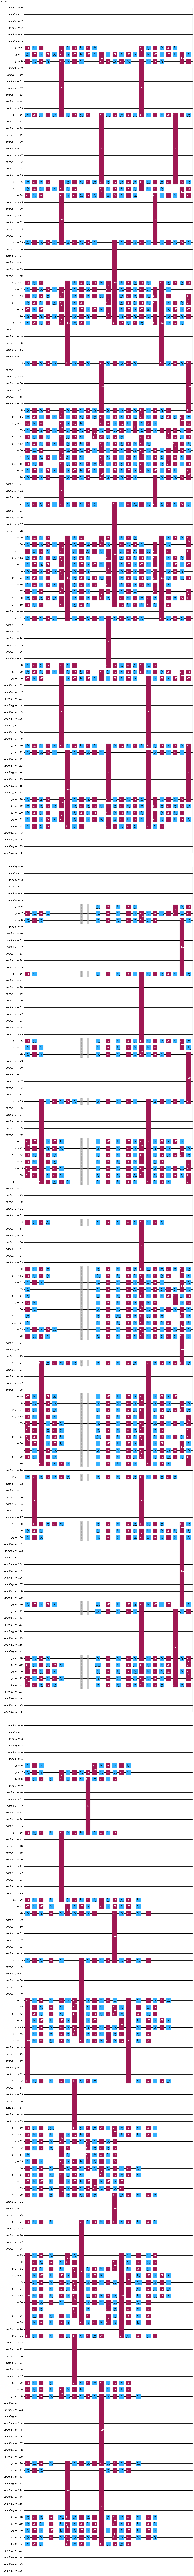

In [ ]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
target_circuit = pm.run(abstract_circuit)
target_circuit.draw('mpl')

#### Target observables

The transpilation process has mapped the virtual qubits of the abstract circuit to physical qubits on the hardware. The information about the qubit layout is stored in the layout attribute of the transpiled target circuit. The observables were defined in terms of the virtual qubits, so we need to apply this layout to the observables, which we can do with the [`apply_layout`](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.SparsePauliOp#apply_layout) method of `SparsePauliOp`.

In [ ]:
layout = target_circuit.layout
target_observables = [abs_obs.apply_layout(layout=layout) for abs_obs in abstract_observables]

### Execution of Jobs


Now, execute the target circuit and observables with different configurations of error mitigation from the `Estimator` primitive. We will submit **7 jobs** where we submit seven different jobs (each with same circuit and observables) with following settings.

- **Job 1**: No suppression/mitigation
- **Job 2**: Dynamical Decoupling
- **Job 3**: Measurement Mitigation (TREX)
- **Job 4**: Zero Noise Extrapolation (ZNE)
   - _Job4a_: ZNE (exponential extrapolator)
   - _Job4b_: ZNE (linear extrapolator)
- **Job 5**: ZNE + Gate Twirling
- **Job 6**: All

In [ ]:
# Define the primitive unified bloc (PUB) for Estimator jobs
pub = (target_circuit, target_observables)
default_shots = 10_000

# list for saving job results
primitive_results = []

# Submit Jobs 1 to 3 inside a Batch execution mode
with Batch(backend=backend) as batch:
    # Job 1: No mitigation
    options_ex1 = EstimatorOptions() # some suppression and mitigation are enabled by default
    options_ex1.optimization_level = 0
    options_ex1.resilience_level = 0
    options_ex1.default_shots = default_shots

    # Instantiate `Estimator` with options
    estimator = Estimator(options=options_ex1)
    # Submit job
    job_ex1 = estimator.run(pubs=[pub])


    # Job 2: Dynamical Decoupling (DD)
    options_ex2 = EstimatorOptions()
    options_ex2.default_shots = default_shots
    options_ex2.optimization_level = 0
    options_ex2.resilience_level = 0
    options_ex2.dynamical_decoupling.sequence_type = "XX"
    options_ex2.dynamical_decoupling.enable = True

    estimator = Estimator(options=options_ex2)
    job_ex2 = estimator.run(pubs=[pub])


    # Job 3: Measurement mitigation (TREX)
    options_ex3 = EstimatorOptions()
    options_ex3.default_shots = default_shots
    options_ex3.optimization_level = 0
    options_ex3.resilience_level = 0

    options_ex3.resilience.measure_mitigation = True
    estimator = Estimator(mode = batch, options=options_ex3)
    job_ex3 = estimator.run(pubs=[pub])

# Wait for first 3 jobs to complete. Fetch results when done
primitive_results.append(job_ex1.result())
primitive_results.append(job_ex2.result())
primitive_results.append(job_ex3.result())

# Submit Jobs 4a, 4b, and 5 inside another Batch execution mode
with Batch(backend=backend) as batch:
    # Job 4a: Zero Noise Extrapolation (extrapolator="exponential" | noise_factors=(1, 3, 5))
    options_ex4a = EstimatorOptions()
    options_ex4a.default_shots = default_shots
    options_ex4a.optimization_level = 0
    options_ex4a.resilience_level = 0
    options_ex4a.resilience.zne_mitigation = True
    options_ex4a.resilience.zne.noise_factors = (1, 3, 5)
    options_ex4a.resilience.zne.extrapolator = 'exponential'

    estimator = Estimator(options=options_ex4a)
    job_ex4a = estimator.run(pubs=[pub])


    # Job 4b: Zero Noise Extrapolation (use: extrapolator="linear" and noise_factors=(1, 3, 5))
    options_ex4b = EstimatorOptions()
    options_ex4b.default_shots = default_shots
    options_ex4b.optimization_level = 0
    options_ex4b.resilience_level = 0
    options_ex4b.resilience.zne_mitigation = True
    options_ex4b.resilience.zne.noise_factors = (1, 3, 5)
    options_ex4b.resilience.zne.extrapolator = 'linear'

    estimator = Estimator(options=options_ex4b)
    job_ex4b = estimator.run(pubs=[pub])


    # Job 5: Gate Twirling + Zero Noise Extrapolation (use: extrapolator=("exponential", "linear") and noise_factors=(1, 3, 5))
    options_ex5 = EstimatorOptions()
    options_ex5.default_shots = default_shots

    options_ex5.optimization_level = 0
    options_ex5.resilience_level = 0

    # Gate Twirling
    options_ex5.twirling.enable_gates = True
    options_ex5.twirling.enable_measure = False
    options_ex5.twirling.num_randomizations = 'auto'
    options_ex5.twirling.shots_per_randomization = 'auto'
    options_ex5.twirling.strategy = 'active-accum'

    # ZNE
    options_ex5.resilience.zne_mitigation = True
    options_ex5.resilience.zne.noise_factors = (1, 3, 5)
    options_ex5.resilience.zne.extrapolator = ("exponential", "linear")

    estimator = Estimator(options=options_ex5)
    job_ex5 = estimator.run(pubs=[pub])

# Wait for next 3 jobs to complete. Fetch results when done
primitive_results.append(job_ex4a.result())
primitive_results.append(job_ex4b.result())
primitive_results.append(job_ex5.result())

# Submit Job 6 in Job execution mode as it is a single job
# Job 6: All
options_ex6 = EstimatorOptions()
options_ex6.default_shots = default_shots

# Dynamical Decoupling
options_ex6.dynamical_decoupling.enable = True
options_ex6.dynamical_decoupling.sequence_type = 'XX'
options_ex6.dynamical_decoupling.extra_slack_distribution = 'middle'
options_ex6.dynamical_decoupling.scheduling_method = 'alap'

# Twirling
options_ex6.twirling.enable_gates = True
options_ex6.twirling.enable_measure = True
options_ex6.twirling.num_randomizations = 'auto'
options_ex6.twirling.shots_per_randomization = 'auto'
options_ex6.twirling.strategy = 'active-accum'

# Measurement Error Mitigation
options_ex6.resilience.measure_mitigation = True
options_ex6.resilience.measure_noise_learning.num_randomizations =  32
options_ex6.resilience.measure_noise_learning.shots_per_randomization = 'auto'

# ZNE
options_ex6.resilience.zne_mitigation = True
options_ex6.resilience.zne.noise_factors = (1, 3, 5)
options_ex6.resilience.zne.extrapolator = 'exponential'

# Note: explicitly set `mode=backend` in Job execution mode.
# Inside Batch context manager, `Estimator` knows the context/backend implicitly
# However, without the context manager, we must set `mode` explicitly
estimator = Estimator(mode=backend, options=options_ex6)
job_ex6 = estimator.run(pubs=[pub])
primitive_results.append(job_ex6.result())

### Analyze

In [ ]:
print(primitive_results)

with open('primitive_results.txt', 'w') as f:
    print(primitive_results, file=f)

[PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(50,), dtype=float64>), stds=np.ndarray(<shape=(50,), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(50,), dtype=float64>), shape=(50,)), metadata={'shots': 10000, 'target_precision': 0.01, 'circuit_metadata': {}, 'num_randomizations': 1})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': False, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': False, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2}), PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(50,), dtype=float64>), stds=np.ndarray(<shape=(50,), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(50,), dtype=float64>), shape=(50,)), metadata={'shots': 10000,

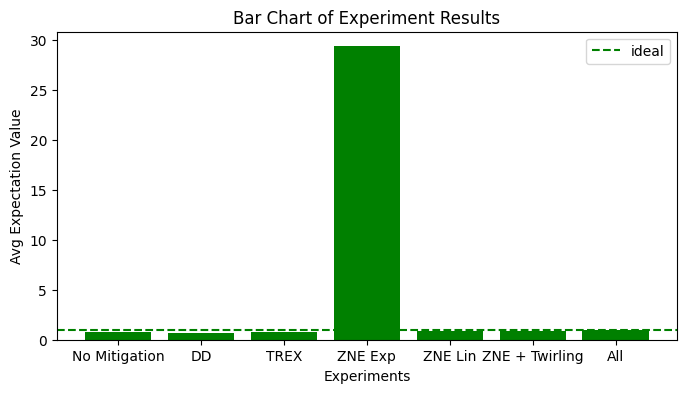

No Mitigation: Average Expectation Value = 0.7361 (Difference from ideal: 0.2639)
DD: Average Expectation Value = 0.7107 (Difference from ideal: 0.2893)
TREX: Average Expectation Value = 0.7565 (Difference from ideal: 0.2435)
ZNE Exp: Average Expectation Value = 29.3433 (Difference from ideal: 28.3433)
ZNE Lin: Average Expectation Value = 0.8261 (Difference from ideal: 0.1739)
ZNE + Twirling: Average Expectation Value = 0.8477 (Difference from ideal: 0.1523)
All: Average Expectation Value = 0.9348 (Difference from ideal: 0.0652)


In [ ]:
# List to store the averages of expectation values
averages = []

# Iterate over each PrimitiveResult
for primitive_result in primitive_results:
    for pub_result in primitive_result:
        # Extract the expectation values
        evs = pub_result.data.evs
        # Compute the average
        average = np.mean(evs)
        averages.append(average)

# Labels for the different methods
labels = ['No Mitigation', 'DD', 'TREX', 'ZNE Exp', 'ZNE Lin', 'ZNE + Twirling', 'All']
ideal_value = 1

# Plotting
plt.figure(figsize=(8, 4))
plt.bar(labels, averages, color='green')
plt.axhline(y=ideal_value, color='g', linestyle='--', label='ideal')
plt.xlabel('Experiments')
plt.ylabel('Avg Expectation Value')
plt.title('Bar Chart of Experiment Results')
plt.legend()
plt.show()

# Analyze the results
for label, avg in zip(labels, averages):
    print(f"{label}: Average Expectation Value = {avg:.4f} (Difference from ideal: {abs(1.0 - avg):.4f})")